In [1]:
import numpy as np
import torch as ch
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from robustness.tools.vis_tools import show_image_column, show_image_row
from robustness.tools.label_maps import CLASS_DICT

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
RES_FILE = '/data/theory/robustopt/shibani/synthfar/Results/objectnet/v0/color/output.csv'

In [3]:
df = pd.read_csv(RES_FILE)

In [4]:
all_keys = ['hue', 'saturation', 'value']

In [5]:
grp_keys = ['labs', 'preds', 'hue', 'saturation', 'value']
df = df.groupby(grp_keys).agg(num=('uids', 'count')).reset_index()

In [6]:
df

,labs,preds,hue,saturation,value,num
0,"[409, 530]",409,0.0,0.0,0.0,8
1,"[409, 530]",409,0.0,0.0,0.1,9
2,"[409, 530]",409,0.0,0.0,0.2,9
3,"[409, 530]",409,0.0,0.0,0.3,10
4,"[409, 530]",409,0.0,0.0,0.4,10
...,...,...,...,...,...,...
2508601,[999],999,1.0,1.0,0.6,17
2508602,[999],999,1.0,1.0,0.7,17
2508603,[999],999,1.0,1.0,0.8,17
2508604,[999],999,1.0,1.0,0.9,16


In [7]:
df['labs_int'] = df.labs.apply(lambda x: [int(xx) for xx in x[1:-1].split(',')])

In [8]:
df['sameclass'] = df.apply(lambda r: r['preds'] in r['labs_int'], axis=1)

In [9]:
df

,labs,preds,hue,saturation,value,num,labs_int,sameclass
0,"[409, 530]",409,0.0,0.0,0.0,8,"[409, 530]",True
1,"[409, 530]",409,0.0,0.0,0.1,9,"[409, 530]",True
2,"[409, 530]",409,0.0,0.0,0.2,9,"[409, 530]",True
3,"[409, 530]",409,0.0,0.0,0.3,10,"[409, 530]",True
4,"[409, 530]",409,0.0,0.0,0.4,10,"[409, 530]",True
...,...,...,...,...,...,...,...,...
2508601,[999],999,1.0,1.0,0.6,17,[999],True
2508602,[999],999,1.0,1.0,0.7,17,[999],True
2508603,[999],999,1.0,1.0,0.8,17,[999],True
2508604,[999],999,1.0,1.0,0.9,16,[999],True


## Over all backgrounds

In [10]:
acc = 100 * np.sum(df['num'][df['sameclass']]) / np.sum(df['num'])
print(f"Mean accuracy over all background configs: {acc: .2f}")

Mean accuracy over all background configs:  28.68


In [11]:
conf_df = df.groupby(['labs', 'preds']).agg({'num': 'sum'}).reset_index()

In [12]:
from objectnet_utils import OBJN_TO_IN_MAP
in_classes = [] 
for v in OBJN_TO_IN_MAP.values():
    in_classes.extend(v)
in_classes = list(set(in_classes))
IN_TO_OBJN = {str(v): k for k, v in OBJN_TO_IN_MAP.items()}
IN_TO_OBJN_IND = {}
for k, v in OBJN_TO_IN_MAP.items():
    for vv in v:
        IN_TO_OBJN_IND[vv] = k

In [13]:
conf_df['labs_to_obj'] = conf_df.apply(lambda r: IN_TO_OBJN[r['labs']], axis=1)

In [14]:
conf_df['preds_to_obj'] = conf_df.apply(lambda r: IN_TO_OBJN_IND[r['preds']], axis=1)
conf_df['sameclass'] = (conf_df['labs_to_obj'] == conf_df['preds_to_obj'])

In [15]:
conf_df

,labs,preds,num,labs_to_obj,preds_to_obj,sameclass
0,"[409, 530]",409,12232,1,1,True
1,"[409, 530]",412,33,1,283,False
2,"[409, 530]",414,4,1,2,False
3,"[409, 530]",419,14682,1,5,False
4,"[409, 530]",434,19,1,108,False
...,...,...,...,...,...,...
5860,[999],851,2,275,287,False
5861,[999],883,422,275,293,False
5862,[999],893,8,275,297,False
5863,[999],902,9,275,306,False


In [16]:
all_labs = list(OBJN_TO_IN_MAP.keys())
Nclasses = len(all_labs)
label_map_r = {l: i for i, l in enumerate(all_labs)}

In [17]:
if False:
    CM = np.zeros((Nclasses, Nclasses))
    for l, p, n in zip(conf_df['labs_to_obj'].values, 
                       conf_df['preds_to_obj'].values, 
                       conf_df['num'].values):
        CM[label_map_r[l], label_map_r[p]] = n
    CM = CM / np.sum(CM, axis=1)

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    sns.heatmap(np.around(CM, decimals=2), cmap='RdBu_r', ax=ax, annot=True)
    #ax.set_xticklabels([CLASS_DICT['CIFAR'][i] for i in range(10)], rotation=30)
    #ax.set_yticklabels([CLASS_DICT['CIFAR'][i] for i in range(10)], rotation=0)

    plt.show()

## Over specific configs

In [18]:
acc_df = df.groupby(all_keys + ['sameclass']).agg({'num': 'sum'}).reset_index()
acc_df = acc_df.pivot_table(index=all_keys, columns='sameclass', values='num').reset_index()
acc_df['acc'] = acc_df[True] / (acc_df[True] + acc_df[False])
del acc_df[True], acc_df[False]

In [19]:
acc_df

sameclass,hue,saturation,value,acc
0,0.0,0.0,0.0,0.2747
1,0.0,0.0,0.1,0.2849
2,0.0,0.0,0.2,0.2868
3,0.0,0.0,0.3,0.2904
4,0.0,0.0,0.4,0.2963
...,...,...,...,...
1326,1.0,1.0,0.6,0.2612
1327,1.0,1.0,0.7,0.2625
1328,1.0,1.0,0.8,0.2616
1329,1.0,1.0,0.9,0.2636


In [20]:
print(f"Min/max accuracy over single background configs: ",
     f" {100 * np.min(acc_df['acc']): .2f}, {100 * np.max(acc_df['acc']): .2f}")

Min/max accuracy over single background configs:    18.74,  34.99


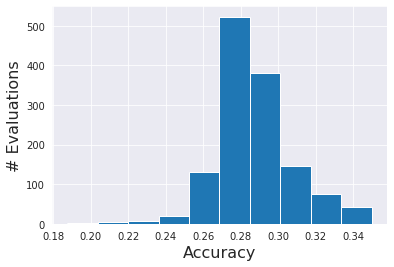

In [21]:
plt.hist(acc_df['acc'])
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('# Evaluations', fontsize=16)
plt.show()

## Best over configs

In [22]:
df

,labs,preds,hue,saturation,value,num,labs_int,sameclass
0,"[409, 530]",409,0.0,0.0,0.0,8,"[409, 530]",True
1,"[409, 530]",409,0.0,0.0,0.1,9,"[409, 530]",True
2,"[409, 530]",409,0.0,0.0,0.2,9,"[409, 530]",True
3,"[409, 530]",409,0.0,0.0,0.3,10,"[409, 530]",True
4,"[409, 530]",409,0.0,0.0,0.4,10,"[409, 530]",True
...,...,...,...,...,...,...,...,...
2508601,[999],999,1.0,1.0,0.6,17,[999],True
2508602,[999],999,1.0,1.0,0.7,17,[999],True
2508603,[999],999,1.0,1.0,0.8,17,[999],True
2508604,[999],999,1.0,1.0,0.9,16,[999],True


In [23]:
perclass_acc_df = df.groupby(all_keys + ['sameclass', 'labs']).agg({'num': 'sum'}).reset_index()
perclass_acc_df = perclass_acc_df.pivot_table(index=all_keys + ['labs'], 
                                              columns='sameclass', values='num',
                                              fill_value=0).reset_index()
perclass_acc_df['acc'] = perclass_acc_df[True] / (perclass_acc_df[True] + perclass_acc_df[False])
perclass_acc_df['count'] = (perclass_acc_df[True] + perclass_acc_df[False])
perclass_acc_df

sameclass,hue,saturation,value,labs,False,True,acc,count
0,0.0,0.0,0.0,"[409, 530]",73,12,0.141176,85
1,0.0,0.0,0.0,[412],63,32,0.336842,95
2,0.0,0.0,0.0,[414],60,18,0.230769,78
3,0.0,0.0,0.0,"[418, 749, 563]",69,10,0.126582,79
4,0.0,0.0,0.0,[419],37,54,0.593407,91
...,...,...,...,...,...,...,...,...
134426,1.0,1.0,1.0,[950],91,7,0.071429,98
134427,1.0,1.0,1.0,[951],53,55,0.509259,108
134428,1.0,1.0,1.0,[954],54,31,0.364706,85
134429,1.0,1.0,1.0,[968],79,9,0.102273,88


In [24]:
avg_df = perclass_acc_df.groupby('labs').agg({'acc': 'mean', 'count': 'sum'}).reset_index()

avg_df

,labs,acc,count
0,"[409, 530]",0.156273,113135
1,[412],0.300589,126445
2,[414],0.326735,103818
3,"[418, 749, 563]",0.158565,105149
4,[419],0.602109,121121
...,...,...,...
96,[950],0.130407,130438
97,[951],0.605052,143748
98,[954],0.463367,113135
99,[968],0.144585,117128


## Per class

In [25]:
perclass_acc_df = perclass_acc_df.loc[perclass_acc_df.groupby('labs')['acc'].idxmax()]

In [26]:
perclass_acc_df

sameclass,hue,saturation,value,labs,False,True,acc,count
109888,0.8,1.0,1.0,"[409, 530]",65,20,0.235294,85
71004,0.5,0.8,1.0,[412],47,48,0.505263,95
15455,0.1,0.2,1.0,[414],34,44,0.564103,78
108780,0.8,0.9,1.0,"[418, 749, 563]",45,34,0.430380,79
76562,0.6,0.2,1.0,[419],27,64,0.703297,91
...,...,...,...,...,...,...,...,...
41001,0.3,0.3,0.9,[950],71,27,0.275510,98
63323,0.5,0.1,1.0,[951],20,88,0.814815,108
32115,0.2,0.6,0.9,[954],22,63,0.741176,85
97766,0.7,1.0,1.0,[968],52,36,0.409091,88


In [27]:
print("Best over configs", 
      100 * sum(perclass_acc_df['acc'] * perclass_acc_df['count']) / sum(perclass_acc_df['count']))

Best over configs 45.54


In [28]:
if False:
    CM_best = np.zeros((10, 10))

    for l, o in zip(perclass_acc_df['labs'], perclass_acc_df['offset']):
        curr = df[np.logical_and(df['labs'] == l, df['offset'] == o)]
        for p, n in zip(curr['preds'], curr['num']):
            CM_best[l, p] = n
    CM_best = CM_best / np.sum(CM_best, axis=1)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    sns.heatmap(np.around(CM_best, decimals=2), cmap='RdBu_r', ax=ax, annot=True)
    ax.set_xticklabels([CLASS_DICT['CIFAR'][i] for i in range(10)], rotation=30)
    ax.set_yticklabels([CLASS_DICT['CIFAR'][i] for i in range(10)], rotation=0)

    plt.show()

## Try all dataset

In [29]:
from pathlib import Path
from torchvision import transforms
from utils import RGBAToRGB, ModelDataset, details_df
from colorsys import hsv_to_rgb, rgb_to_hsv
from make_predictions import make_predictions

In [30]:
print(len(set(perclass_acc_df['labs'])), len(OBJN_TO_IN_MAP))

101 113


In [31]:
DS_PATH = '/scratch/datasets/sandbox/v0'
ds_path = Path(DS_PATH)
root_df = details_df(ds_path)

In [95]:
from robustness import datasets
ds = datasets.ImageNet((ds_path, root_df))

In [97]:
from robustness.model_utils import make_and_restore_model
m, _ = make_and_restore_model(arch='resnet50', 
                                          dataset=datasets.ImageNet('/scratch/engstrom_scratch/imagenet'),
                                          pytorch_pretrained=True)
m.eval()
m = ch.nn.DataParallel(m.cuda())

In [98]:
class Flatten():
    def __init__(self):
        print("Init")

    def __call__(self, im, target=None):
        if type(im) == tuple:
            im = im[0]
        return im

class UnFlatten():
    def __call__(self, im, target=None):
        return (im, target)

In [99]:
ds.custom_class = ModelDataset

ds.transform_test = transforms.Compose([
            #RGBAToRGB(hsv_to_rgb(1, 1, 1)),
            #transforms.CenterCrop(224),
            Flatten(),
            transforms.ToTensor()
        ])
_, loader = ds.make_loaders(workers=10, 
                                    batch_size=2000, 
                                    only_val=True)

Init
==> Preparing dataset imagenet..


In [100]:
perclass_acc_df

sameclass,hue,saturation,value,labs,False,True,acc,count
109888,0.8,1.0,1.0,"[409, 530]",65,20,0.235294,85
71004,0.5,0.8,1.0,[412],47,48,0.505263,95
15455,0.1,0.2,1.0,[414],34,44,0.564103,78
108780,0.8,0.9,1.0,"[418, 749, 563]",45,34,0.430380,79
76562,0.6,0.2,1.0,[419],27,64,0.703297,91
...,...,...,...,...,...,...,...,...
41001,0.3,0.3,0.9,[950],71,27,0.275510,98
63323,0.5,0.1,1.0,[951],20,88,0.814815,108
32115,0.2,0.6,0.9,[954],22,63,0.741176,85
97766,0.7,1.0,1.0,[968],52,36,0.409091,88


In [101]:
class_specific_transforms = {}
class_specific_transforms_info = {}

for i in range(len(perclass_acc_df)):
    d = perclass_acc_df.iloc[i]
    res = [d[k] for k in ['labs',  'hue', 'saturation', 'value']]
    labs, h, s, v = res
    class_specific_transforms[str(labs)] = transforms.Compose([
                                                transforms.ToPILImage(),
                                                UnFlatten(),
                                                RGBAToRGB(hsv_to_rgb(h, s, v)),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor()
                                            ])
    class_specific_transforms_info[str(labs)] = (h, s, v)

In [106]:
from tqdm import tqdm

mode = 'restrict'

in_classes = [] 
for v in OBJN_TO_IN_MAP.values():
    in_classes.extend(v)
in_classes = list(set(in_classes))

res_dfs = []
with ch.no_grad():
    for jj, (ims, labs, uids) in tqdm(enumerate(loader), total=len(loader)):
        labs = [OBJN_TO_IN_MAP[int(l)] for l in labs.cpu()]
        info = [class_specific_transforms_info[str(l)] for l in labs]
        
        ims = ch.stack([class_specific_transforms[str(l)](im)
                      for im, l in zip(ims, labs) 
                      if str(l) in class_specific_transforms])
        ims = ims[:,:3,...].cuda() # RGBA -> RGB
        op = m(ims)[0]
        if mode != 'restrict':
            preds = ch.argmax(op, dim=1).cpu()
        else:
            op = op[:, in_classes]
            preds = ch.argmax(op, dim=1).cpu()
            preds = ch.tensor([in_classes[int(p)] for p in preds])
        res_dfs.append(pd.DataFrame({'uids': uids,
                                'preds': preds.cpu().numpy(),
                                'labs': labs,
                                'info': info}))
        #if jj == 5: break
res_dfs = pd.concat(res_dfs)















  0%|          | 0/502 [00:00<?, ?it/s]













  0%|          | 1/502 [00:56<7:51:04, 56.42s/it]













  0%|          | 2/502 [01:13<6:10:48, 44.50s/it]













  1%|          | 3/502 [01:25<4:49:21, 34.79s/it]













  1%|          | 4/502 [01:36<3:51:14, 27.86s/it]













  1%|          | 5/502 [01:48<3:09:34, 22.89s/it]













  1%|          | 6/502 [01:59<2:39:36, 19.31s/it]













  1%|▏         | 7/502 [02:09<2:16:40, 16.57s/it]













  2%|▏         | 8/502 [02:19<2:01:46, 14.79s/it]













  2%|▏         | 9/502 [02:32<1:55:24, 14.05s/it]













  2%|▏         | 10/502 [02:44<1:50:50, 13.52s/it]













  2%|▏         | 11/502 [02:56<1:47:32, 13.14s/it]













  2%|▏         | 12/502 [03:07<1:41:16, 12.40s/it]













  3%|▎         | 13/502 [03:17<1:36:03, 11.79s/it]













  3%|▎         | 14/502 [03:28<1:33:04, 11.44s/it]













  3%|▎         | 15/502 [03:39<1:32:50, 11.44s

In [107]:
res_dfs['sameclass'] = res_dfs.apply(lambda r: r['preds'] in r['labs'], axis=1)

In [108]:
print(np.mean(res_dfs['sameclass']))

0.42635116940108714


In [105]:
#res_dfs.to_csv('debug.csv')

In [109]:
res_dfs.to_csv('whole_eval.csv')